## Test of the xLstm

In [337]:
import torch
import torch.nn as nn
from xlstm_faster import KANxLSTM
import time
import numpy as np
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 =  KANxLSTM(5, 2, 1, "ms", batch_first=True, proj_factor_slstm=4/3, proj_factor_mlstm=2) #input_size, head_size, num_heads, proj_factor=2

        self.fc1 = nn.Linear(420, 32)
        self.dr = nn.Dropout(0.8)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        #print(x.shape)
        x = torch.tanh(x.reshape(x.shape[0], -1))
        x = self.dr(x)
        x = self.fc1(x)

        x = torch.relu(x)
        x = self.fc3(x)
        return x

    
def get_model_memory_usage(model):
    mem_usage = 0
    for param in model.parameters():
        mem_usage += np.prod(list(param.size())) * param.element_size()
        
    return mem_usage
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
x = torch.randn(64, 30, 14)
model_xlstm = Net()
start = time.time()

out = model_xlstm(x)

end_time = time.time()  # 再次获取当前时间

elapsed_time = end_time - start  # 计算经过的时间
mem_usage = get_model_memory_usage(model_xlstm)
print(f"模型内存占用: {mem_usage/1024} M")
print(f"kan代码运行时间: {elapsed_time} 秒")
print(f"模型的参数数量: {count_parameters(model_xlstm)} 个")
print(out.shape)


AssertionError: 

In [ ]:
'''
报错日志：9.21将model改为model_xlstm后报错
'''

## RUL prediction using Long Short Term Memory (LSTM) FD001

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of LSTM. Readers who want to get an intuitive understanding of LSTMs, should read [this excellent blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah.

In [156]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [157]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.23.5
Pandas version:  2.2.2
Scikit-learn version:  1.4.0


#### Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: Standard scaling and Full dataset scaling.

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [159]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score


In [160]:
# import os
# import pandas as pd

# # Prompt the user for the flight condition
# flight_condition = input("Please enter the flight condition (1-4): ")

# # Validate the user input
# while flight_condition not in ['1', '2', '3', '4']:
#     print("Invalid input. Please try again.")
#     flight_condition = input("Please enter the flight condition (1-4): ")

# # Set the file names based on the flight condition
# train_file = f'train_FD00{flight_condition}.txt'
# test_file = f'test_FD00{flight_condition}.txt'
# rul_file = f'RUL_FD00{flight_condition}.txt'

# # Load the train dataset as a dataframe
# train_dataset_path = os.path.join('./Data', train_file)
# train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# # Load the test dataset as a dataframe
# test_dataset_path = os.path.join('./Data', test_file)
# test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# # Load the RUL dataset as a dataframe
# rul_dataset_path = os.path.join('./Data', rul_file)
# true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



In [246]:
import os
import pandas as pd

# Set the file names based on the flight condition
train_file = f'training_data1.csv'
test_file = f'testing_data1.csv'

# # Load the train dataset as a dataframe
# train_dataset_path = os.path.join('./Data', train_file)
# train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# # Load the test dataset as a dataframe
# test_dataset_path = os.path.join('./Data', test_file)
# test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('./Data', train_file)
train_data = pd.read_csv(train_dataset_path)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('./Data', test_file)
test_data = pd.read_csv(test_dataset_path)

# Display the first 5 rows of the train data
print("Train Data:")
print(train_data.head())

# Display the first 5 rows of the test data
print("\nTest Data:")
print(test_data.head())


Train Data:
   Cycle  Time Measured(Sec)  Voltage Measured(V)  Current Measured  \
0      0            3690.234             3.277170         -0.006528   
1      0            3690.234             2.475768         -2.009436   
2      0            3690.234             3.062113         -0.001433   
3      1            3672.344             3.300245         -0.000448   
4      1            3672.344             2.351526         -2.010375   

   Temperature Measured  Capacity(Ah) SampleId  
0             34.230853      1.856487    B0005  
1             39.162987      2.035338    B0006  
2             37.338478      1.891052    B0007  
3             34.392137      1.846327    B0005  
4             39.246203      2.025140    B0006  

Test Data:
   Cycle  Time Measured(Sec)  Voltage Measured(V)  Current Measured  \
0      0            3434.891             3.053230         -0.002433   
1      1            3425.485             3.088200         -0.000911   
2      2            3410.375             3

In [247]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [248]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int64(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [249]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int64(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [250]:
N = 164 # 窗口数
window_length = 4
shift = 1

# early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
# num_test_windows = 5
# processed_test_data = []
# num_test_windows_list = []

columns_to_be_dropped = ['Cycle', 'SampleId']

train_data_first_column = train_data['SampleId']
test_data_first_column = test_data['SampleId']


In [251]:
# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data_first_column.unique())
num_test_machines = len(test_data_first_column.unique())

print(train_data)

         0         1         2         3         4         5
0    B0005  2.280057  0.011279  0.339273 -1.170807  1.289866
1    B0006  2.280057 -1.887288 -2.904905  1.139975  2.148857
2    B0007  2.280057 -0.498204  0.347525  0.285165  1.455876
3    B0005   2.20731  0.065945  0.349122 -1.095243  1.241069
4    B0006   2.20731 -2.181624 -2.906426  1.178964   2.09988
..     ...       ...       ...       ...       ...       ...
499  B0006  -1.33177  0.996544  0.347831 -2.042132 -1.983336
500  B0007  -1.33177  0.236288  0.346621  0.815617 -0.797937
501  B0005 -1.257054  0.752242  0.348902 -1.088785 -1.262407
502  B0006 -1.257054  0.993582  0.344782  -2.12589 -1.931944
503  B0007 -1.257054  0.264025  0.348252  0.525571 -0.746696

[504 rows x 6 columns]


In [220]:
print(num_train_machines)
print(num_test_machines)

3
1


In [252]:
# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

c = ['B0005', 'B0006', 'B0007']
# Process trianing data
for i in np.arange(0, num_train_machines):
    temp_train_data = train_data[train_data[0] == c[i]].drop(columns = [0]).values
    print(len(temp_train_data))

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    data_ls_x=[]
    #data_ls_target=[]
    X = [None] * N
    #Y = [None] * N

    for j in range(N):
        X[j] = temp_train_data[j:j+window_length]
        data_ls_x.append(X[j])
        #last_elements = [inner_list[-1] for inner_list in temp_train_data]
        #Y[j] = last_elements[4:] 
        #data_ls_target.append(Y[j])

#     temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)  
#     data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
#                                                                                 window_length = window_length, shift = shift)
    last_elements = [inner_list[-1] for inner_list in temp_train_data]
    data_ls_target = last_elements[4:]
    processed_train_data.append(data_ls_x)
    processed_train_targets.append(data_ls_target)

    # print(processed_train_targets)

 # 如果不止有一个电池数据，则将来自所有电池的样本竖向拼接
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

'''因为还没有加上cycle，所以先没有随机打乱排序///但是查资料后得知打乱后无法还原原有顺序也没关系因为只是为了训练模型。所以认为可以不加cycle直接打乱'''
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

168
168
168
Processed trianing data shape:  (492, 4, 5)
Processed training ruls shape:  (492,)


In [253]:
print(processed_train_data)

[[[0.48417959468707245 0.1197242663999876 0.34303579046617
   -0.3685113392457318 0.40128829097701973]
  [0.4442193333455438 0.12903867985760828 0.34243251718076023
   -0.39208668759191506 0.34981282297537053]
  [0.4498065317869047 0.1515982603757507 0.34301063437251045
   -0.36090146708820786 0.30352236256024806]
  [0.40901673006543515 0.19857953226525135 0.3423469482365878
   -0.3244430687428969 0.2507578289257454]]

 [[-0.3679128977391157 0.09978891007009688 0.3467224142912608
   1.28257018522335 -0.03818742186385943]
  [-0.40317649663539584 0.1038986292387333 0.3469103715007416
   1.2983092183677272 -0.06102577879631372]
  [-0.4412987567429404 0.10813834796330542 0.3457749247874509
   1.307009532880178 -0.08705752163947568]
  [-0.4382489759343368 0.15458563946302534 0.3479031325786797
   1.2117930860208195 -0.0848575619518302]]

 [[2.125726148105145 -1.9737190340263486 -2.9073531321194634
   0.9886039634429215 2.0458908434176477]
  [2.119817706085277 -2.3482132091090717 -2.90908233

In [254]:
c1 = ['B0018']
processed_test_data=[]
processed_test_targets=[]

N1 = 128 # 窗口数
window_length = 4
shift = 1

# Process test data
for i in np.arange(0, num_test_machines):
    temp_test_data = test_data[test_data[0] == c1[i]].drop(columns = [0]).values
    print(len(temp_test_data))

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    data_ls_x=[]
    X = [None] * N1

    for j in range(N1):
        X[j] = temp_test_data[j:j+window_length]
        data_ls_x.append(X[j])


    last_elements = [inner_list[-1] for inner_list in temp_test_data]
    data_ls_target = last_elements[4:]

    processed_test_data.append(data_ls_x)
    processed_test_targets.append(data_ls_target)

 # 如果不止有一个电池数据，则将来自所有电池的样本竖向拼接
processed_test_data = np.concatenate(processed_test_data)
processed_test_targets = np.concatenate(processed_test_targets)

print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", processed_test_targets.shape)

print(processed_test_data)
print(processed_test_targets)


# temp_test_data = test_data[test_data[0] == c1[i]].drop(columns = [0]).values
# if (len(temp_test_data) < window_length):
#     print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
#     raise AssertionError("Window length is larger than number of data points for some engines. "
#                          "Try decreasing window length.")

# # Prepare test data
# test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
#                                                          num_test_windows = num_test_windows)

# processed_test_data.append(test_data_for_an_engine)
# num_test_windows_list.append(num_windows)

# processed_test_data = np.concatenate(processed_test_data)
# #true_rul = true_rul[0].values

# print("Processed test data shape: ", processed_test_data.shape)

132
Processed test data shape:  (128, 4, 5)
True RUL shape:  (128,)
[[[1.2417370147953748 -0.5192466422094877 0.34590531825908044
   0.2229424079715533 1.282744186619505]
  [1.203488697081075 -0.43640116892246855 0.3483717962240358
   0.19942475265788007 1.2260273880135617]
  [1.1420457797237413 -0.46327221975155597 0.34873747878132405
   -0.022943745799801855 1.208767435279065]
  [1.1190463660524592 -0.40270433829690633 0.3457210167899506
   -0.3209110922971178 1.1658864505858002]]

 [[1.203488697081075 -0.43640116892246855 0.3483717962240358
   0.19942475265788007 1.2260273880135617]
  [1.1420457797237413 -0.46327221975155597 0.34873747878132405
   -0.022943745799801855 1.208767435279065]
  [1.1190463660524592 -0.40270433829690633 0.3457210167899506
   -0.3209110922971178 1.1658864505858002]
  [1.1715920561974928 -0.36664668692783403 0.34498411056427963
   0.1662170807387282 1.1756199200813855]]

 [[1.1420457797237413 -0.46327221975155597 0.34873747878132405
   -0.022943745799801855 

#### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [255]:
import torch
from torch.utils.data import Dataset, DataLoader
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)


Processed train data shape:  (393, 4, 5)
Processed validation data shape:  (99, 4, 5)
Processed train targets shape:  (393,)
Processed validation targets shape:  (99,)


In [256]:
print(processed_train_data)

[[[0.5535641412700096 -0.030410700764271856 0.3478152668512474
   -0.13746981731947938 0.5772254290046337]
  [0.5553411468878222 0.011871011605275011 0.34585532677915576
   -0.09319370853378155 0.5267319612467448]
  [0.5207810307647275 0.08796971546849336 0.34379595607661667
   -0.3117166529376041 0.4521342350673779]
  [0.48417959468707245 0.1197242663999876 0.34303579046617
   -0.3685113392457318 0.40128829097701973]]

 [[-1.0412801020323132 0.7815022389188444 0.34590645531257014
   -1.0375603130152207 -1.1219584550193025]
  [-1.0389297376224829 0.7690241649481899 0.3391472813362163
   -0.8295537908217496 -1.1204232001165855]
  [-1.0381042636169542 0.7578682680042949 0.3494859304731984
   -0.7661044095216761 -1.1201243716146305]
  [-1.0757182269230647 0.76542060634965 0.3498664028245247
   -0.8708365898034426 -1.1460065585227506]]

 [[-0.14000481109937724 0.608412786254528 0.3499451219122754
   -0.6853749201946147 -0.11057462688921489]
  [-0.13721121187869678 0.6119669879490987 0.3488

In [257]:
print(processed_train_data.shape)

(393, 4, 5)


In [263]:
all_floats = all(isinstance(l, float) for i in processed_train_data for j in i for l in j)
print(all_floats)

True


In [270]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        # 若data是一个三维列表，我们需要将其转换为NumPy数组
        self.data = np.array(data)  # 首先转换为NumPy数组
        self.data = self.data.astype(np.float32)  # 确保数据类型为float32
        # self.targets = torch.from_numpy(targets)  # 目标已经是NumPy数组，直接转换
        self.targets = torch.from_numpy(targets.astype(np.float32)) # 运行lstm模型说有float64后，添加了此行，注释了上面一行（不这样改targets仍然是float64）。但为什么训练xlstm的时候没有问题？...似乎当时也是改了xlstm的代码，在后面解决了float64的问题
        # 现在不改lstm模块代码也能跑通了

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 确保返回的是PyTorch张量
        return torch.from_numpy(self.data[idx]), self.targets[idx]

# 假设processed_train_data和processed_val_data是三维列表
# 我们需要将它们转换为NumPy数组，然后创建CustomDataset对象
train_dataset = CustomDataset(processed_train_data, processed_train_targets)
val_dataset = CustomDataset(processed_val_data, processed_val_targets)

# 创建训练数据加载器和验证数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# note: 批次的划分是在数据加载器（dataloaders）中处理的，是通过 DataLoader 类从 PyTorch 中创建的

In [271]:
sample_data, sample_targets = train_dataset[0]

# 打印样本数据的形状
print("Shape of the first data sample:", sample_data.shape)

# 打印样本数据的数据类型
print("Data type of the data sample:", sample_data.dtype)

# 打印样本目标的形状
print("Shape of the first target sample:", sample_targets.shape)

# 打印样本目标的数据类型
print("Data type of the target sample:", sample_targets.dtype)

Shape of the first data sample: torch.Size([4, 5])
Data type of the data sample: torch.float32
Shape of the first target sample: torch.Size([])
Data type of the target sample: torch.float32


#### xLSTM model

In [230]:
import torch
from torch import nn
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 =  KANxLSTM(5, 2, 1, "ms", batch_first=True, proj_factor_slstm=4/3, proj_factor_mlstm=2) #input_size, head_size, num_heads, proj_factor=2 
        # note: batch_first=True 是一个参数，用于指定张量中批次维度的位置。在循环神经网络（如 LSTM）中，输入数据通常是一个四维张量，其形状为：batch_first=True: (batch_size, seq_length, input_size);batch_first=False: (seq_length, batch_size, input_size)
        
        self.fc1 = nn.Linear(20, 32)
        self.dr = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        #print(x.shape)
        x = torch.tanh(x.reshape(x.shape[0], -1))
        x = self.dr(x)
        x = self.fc1(x)

        x = torch.relu(x)
        x = self.fc3(x)
        return x

def create_compiled_model():
    model = Net()
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

We will use a `Learning rate scheduler` callback that will change the learning rate after 5 epochs.

In [231]:
from torch.optim import lr_scheduler

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                if labels.dtype != torch.float32:
                    labels = labels.float() # 注意这一步！

                model.to(device)
                assert inputs.dtype == torch.float32, "Outputs must be of type float32"  # 辅助debug步骤
                assert labels.dtype == torch.float32, "Labels must be of type float32"   # 辅助debug步骤
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    assert outputs.dtype == torch.float32, "Data must be of type float32"  # 辅助debug步骤
                    loss = loss_fn(outputs.squeeze(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if epoch % 40 == 0:
                print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

    return model

model, loss_fn, optimizer = create_compiled_model()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=400)

Epoch 0/399
----------
train Loss: 0.3613
val Loss: 0.0697
Epoch 10/399
----------
Epoch 20/399
----------
Epoch 30/399
----------
Epoch 40/399
----------
train Loss: 0.0564
val Loss: 0.0227
Epoch 50/399
----------
Epoch 60/399
----------
Epoch 70/399
----------
Epoch 80/399
----------
train Loss: 0.0385
val Loss: 0.0180
Epoch 90/399
----------
Epoch 100/399
----------
Epoch 110/399
----------
Epoch 120/399
----------
train Loss: 0.0357
val Loss: 0.0124
Epoch 130/399
----------
Epoch 140/399
----------
Epoch 150/399
----------
Epoch 160/399
----------
train Loss: 0.0383
val Loss: 0.0139
Epoch 170/399
----------
Epoch 180/399
----------
Epoch 190/399
----------
Epoch 200/399
----------
train Loss: 0.0346
val Loss: 0.0134
Epoch 210/399
----------
Epoch 220/399
----------
Epoch 230/399
----------
Epoch 240/399
----------
train Loss: 0.0342
val Loss: 0.0130
Epoch 250/399
----------
Epoch 260/399
----------
Epoch 270/399
----------
Epoch 280/399
----------
train Loss: 0.0319
val Loss: 0.012

Why did we run the model only for 10 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 10 epochs as that gives a good enough test error.

In [232]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    # processed_test_data 是一个三维列表，首先将其转换为 NumPy 数组（这里所有元素已经是数值类型且为相同类型）
    test_data_array = np.array(processed_test_data).astype(np.float32)
    
    '''
    # 如果需要，调整数组的形状以符合模型的输入要求
    # 例如，如果模型期望的形状是 [batch_size, channels, height]
    test_data_array = test_data_array.reshape((new_batch_size, channels, height))'''
    
    # 转换为 PyTorch 张量并移动到设备
    data = torch.from_numpy(test_data_array).to(device)
    
    # Forward pass
    outputs = model(data)  # Forward pass
    rul_pred = outputs.cpu().numpy().reshape(-1)  
RMSE = np.sqrt(mean_squared_error(processed_test_targets, rul_pred))
print("RMSE: ", RMSE)

RMSE:  0.1868662425267141


We will now compute the RMSE by taking only last example of each engine.

In [180]:
# num_test_windows_list = 128

In [181]:
# indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
# preds_for_last_example = np.concatenate(rul_pred)[indices_of_last_examples]

# RMSE_new = np.sqrt(mean_squared_error(processed_test_targets, preds_for_last_example))
# print("RMSE (Taking only last examples): ", RMSE_new)

If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [182]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [233]:
s_score = compute_s_score(processed_test_targets, rul_pred)
print("S-score: ", s_score)

S-score:  1.4176580862479253


## Results of xLSTM
##### 训练的模型好坏似乎有......随机性？

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

In [184]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

#### Last 5 preds

In [234]:
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():  # Turn off gradients for prediction
#     data = torch.from_numpy(processed_test_data).float().to(device)  # Convert the data to the correct type and device
#     outputs = model(data)  # Forward pass
#     rul_pred = outputs.cpu().numpy().reshape(-1)  
# preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
# mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
#                              for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(processed_test_targets, rul_pred))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(processed_test_targets, rul_pred))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(processed_test_targets, rul_pred)
print("MAE   " , MAE_perc)


s_score = compute_s_score(processed_test_targets, rul_pred)
print("S-score: ", s_score)

RMSE:  0.1868662425267141
MAE 0.12509223161068644
MAE    0.3767819858948427
S-score:  1.4176580862479253


We will now compute the RMSE by taking only last example of each engine.

In [186]:
# indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
# preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

# RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
# print("RMSE (Taking only last examples): ", RMSE_new)
# MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
# print("% MAE only last examples  " ,MAE_new)

# MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
# print("% MAE only last examples  " , MAE_perc)
# s_score = compute_s_score(true_rul, preds_for_last_example)
# print("S-score: ", s_score)

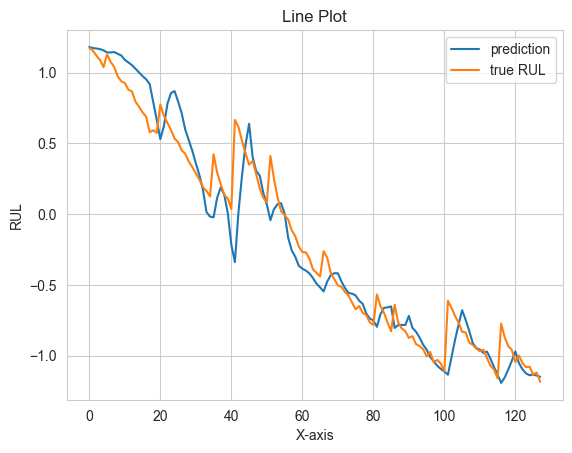

In [235]:
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('RUL')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(rul_pred, processed_test_targets)

C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method='silverman'`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='type', y='value', data=df, split=True, in

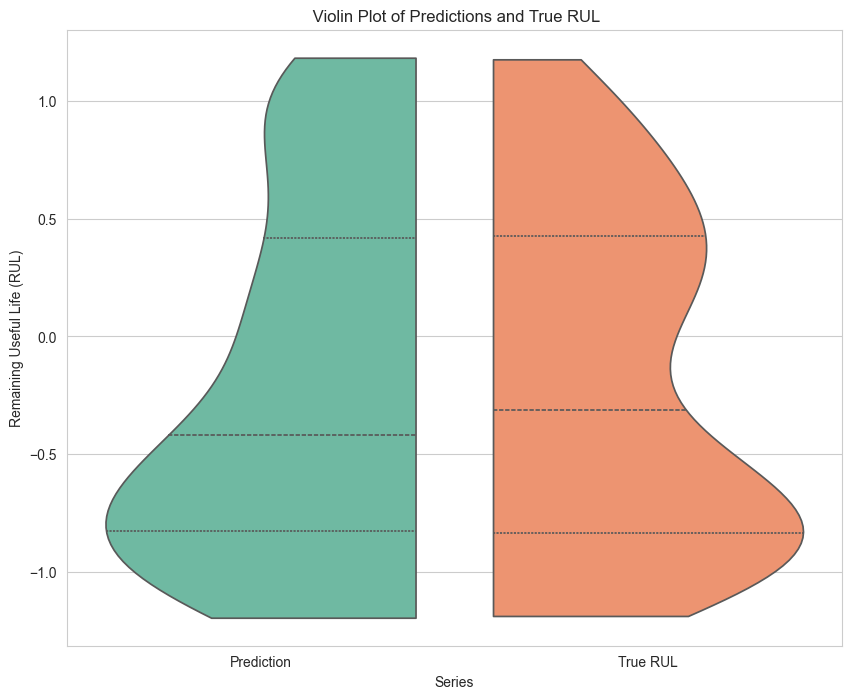

In [239]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series_violin(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8)

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series_violin(rul_pred, processed_test_targets)


In [240]:
# 这个小提琴图看着怎么怪怪的

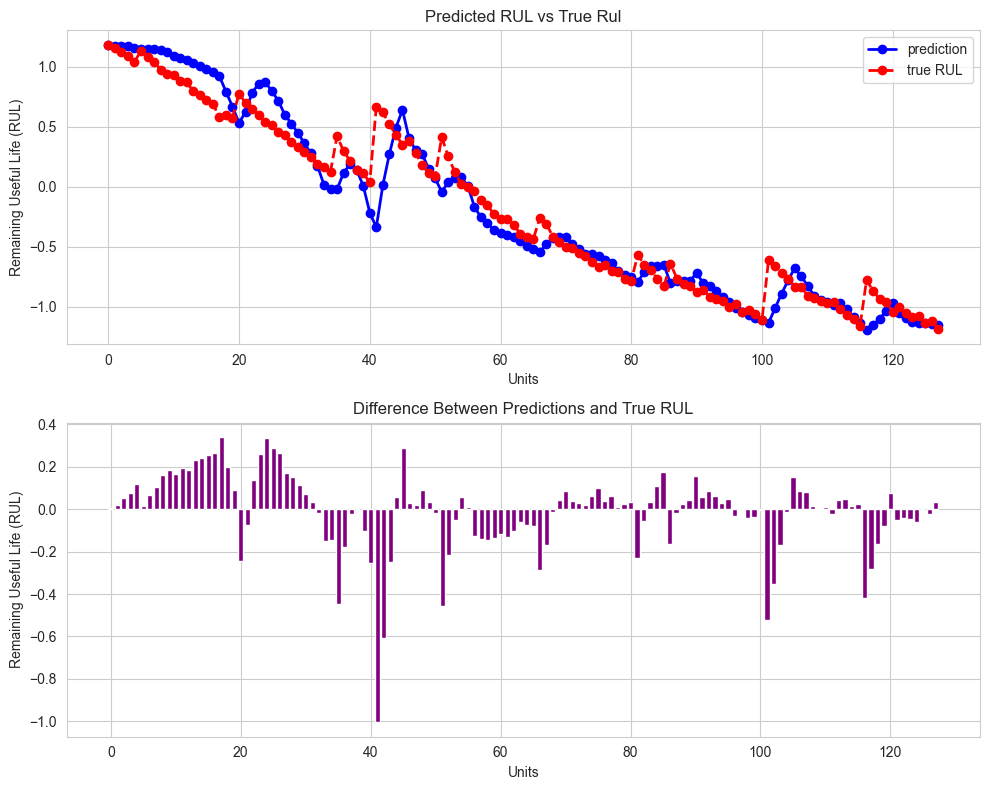

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series_diff(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series_diff(rul_pred, processed_test_targets)


In [242]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [243]:
mae = evaluate_critical_mae(processed_test_targets, rul_pred)
print(f"The MAE for critical predictions is: {mae}")


The MAE for critical predictions is: 0.12509223161068644


# CNN

In [193]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [194]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.15.0
Numpy version:  1.23.5
Pandas version:  2.2.2
Scikit-learn version:  1.4.0


In [195]:
class CustomScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super(CustomScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val).flatten()
        custom_score = self.calculate_custom_score(self.y_val, y_pred)
        print(f'Epoch {epoch+1} - Custom Score: {custom_score:.4f}')

    def compute_s_score(y_true, y_pred):
        """
        Both rul_true and rul_pred should be 1D numpy arrays.
        """
        diff = y_pred - y_true
        return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [196]:
pip install tensorflow_addons

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [197]:
def create_compiled_model():
    model_cnn = Sequential([
        layers.Conv1D(256, 3, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 1, activation = "relu"),
        layers.Conv1D(32, 1, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model_cnn.compile(loss = "mse",metrics=["mae"], optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model_cnn

In [198]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [199]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [200]:
# Create Early Stopping and Reduce Learning Rate on Plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

In [201]:
callback =[tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1), early_stopping , reduce_lr]

In [202]:
print(processed_train_data.dtype, processed_train_targets.dtype)
print(processed_val_data.dtype, processed_val_targets.dtype)

object float64
object float64


In [203]:
processed_train_data = processed_train_data.astype('float32')
processed_train_targets = processed_train_targets.astype('float32')
processed_val_data = processed_val_data.astype('float32')
processed_val_targets = processed_val_targets.astype('float32')

In [204]:
model_cnn = create_compiled_model()
history = model_cnn.fit(processed_train_data, processed_train_targets, epochs = 25,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
7/7 - 1s - loss: 0.7560 - mae: 0.7432 - val_loss: 0.4520 - val_mae: 0.5465 - lr: 0.0010 - 782ms/epoch - 112ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
7/7 - 0s - loss: 0.2743 - mae: 0.4013 - val_loss: 0.0405 - val_mae: 0.1574 - lr: 0.0010 - 32ms/epoch - 5ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
7/7 - 0s - loss: 0.0748 - mae: 0.2182 - val_loss: 0.0743 - val_mae: 0.2298 - lr: 0.0010 - 32ms/epoch - 5ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
7/7 - 0s - loss: 0.0374 - mae: 0.1505 - val_loss: 0.0342 - val_mae: 0.1442 - lr: 0.0010 - 51ms/epoch - 7ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
7/7 - 0s - loss: 0.0387 - mae: 0.1467 - val_loss: 0.0163 - val_mae: 0.0986 - lr: 0.0010 - 32ms/epoch - 5ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001

In [205]:
model_cnn.save("ID_CNN_RUL.h5")

d:\Python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Results of CNN

In [207]:
processed_test_data = processed_test_data.astype('float32')
processed_test_targets = processed_test_targets.astype('float32')

rul_pred_cnn = model_cnn.predict(processed_test_data).reshape(-1) #?
# true_rul= np.clip(processed_test_targets, a_min=0, a_max=125)
# rul_pred = np.clip(rul_pred, a_min=0, a_max=125)

4/4 [==============================] - 0s 1ms/step


In [208]:
RMSE = np.sqrt(mean_squared_error(processed_test_targets, rul_pred_cnn))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(processed_test_targets, rul_pred_cnn))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(processed_test_targets, rul_pred_cnn)
print("MAE   " , MAE_perc)


s_score = compute_s_score(processed_test_targets, rul_pred_cnn)
print("S-score: ", s_score)

RMSE:  0.18560672
MAE 0.13110363
MAE    0.28363845
S-score:  1.3126314


In [210]:
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

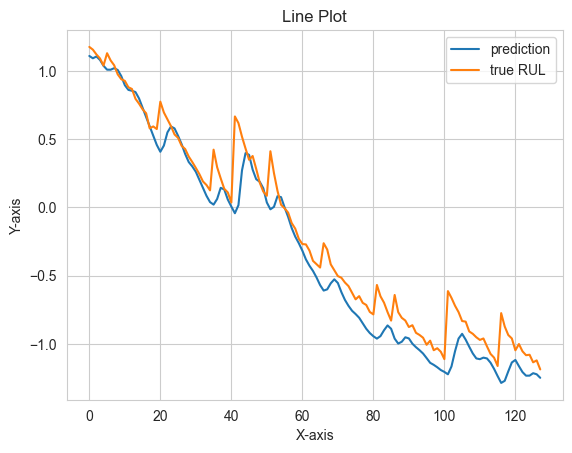

In [211]:
plot_series( rul_pred_cnn,processed_test_targets)

C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method='silverman'`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='type', y='value', data=df, split=True, in

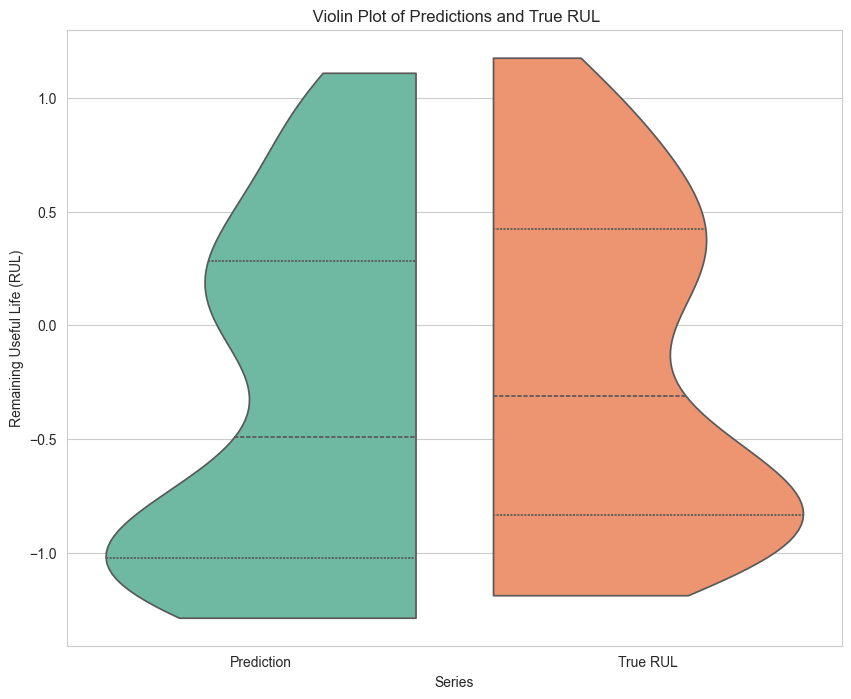

In [212]:
plot_series_violin(rul_pred_cnn, processed_test_targets)

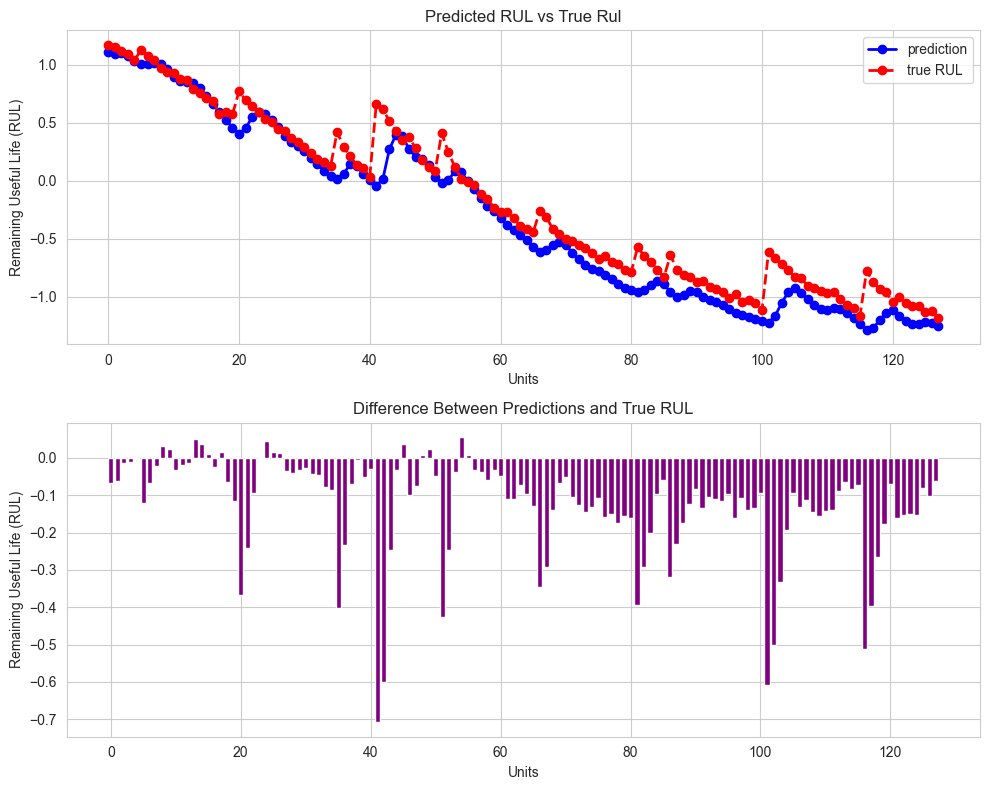

In [214]:
# Call the function
plot_series_diff(rul_pred_cnn, processed_test_targets)

# LSTM

In [244]:
import torch
from torch import nn
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm1 = nn.LSTM(14, 128, batch_first=True)

        self.fc1 = nn.Linear(128, 32)
        self.dr = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)

        x = torch.tanh(x)
        x = self.dr(x)
        x = self.fc1(x[:, -1, :])

        x = torch.relu(x)
        x = self.fc3(x)
        return x

def create_compiled_model():
    model_lstm = Net()
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model_lstm.parameters(), lr=0.01)
    return model_lstm, loss_fn, optimizer

In [ ]:
processed_test_data = processed_test_data.float()

In [272]:
from torch.optim import lr_scheduler

def train_model(model_lstm, loss_fn, optimizer, scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model_lstm.train()  # Set model to training mode
            else:
                model_lstm.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                model_lstm.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_lstm(inputs)
                    loss = loss_fn(outputs.squeeze(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if epoch % 10 == 0:
                print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

    return model_lstm

model_lstm, loss_fn, optimizer = create_compiled_model()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_lstm = train_model(model_lstm, loss_fn, optimizer, exp_lr_scheduler, num_epochs=120)

Epoch 0/119
----------
train Loss: 0.2701
val Loss: 0.0955
Epoch 10/119
----------
train Loss: 0.0314
val Loss: 0.0183
Epoch 20/119
----------
train Loss: 0.0313
val Loss: 0.0233
Epoch 30/119
----------
train Loss: 0.0209
val Loss: 0.0140
Epoch 40/119
----------
train Loss: 0.0140
val Loss: 0.0118
Epoch 50/119
----------
train Loss: 0.0132
val Loss: 0.0120
Epoch 60/119
----------
train Loss: 0.0122
val Loss: 0.0110
Epoch 70/119
----------
train Loss: 0.0128
val Loss: 0.0113
Epoch 80/119
----------
train Loss: 0.0120
val Loss: 0.0117
Epoch 90/119
----------
train Loss: 0.0119
val Loss: 0.0113
Epoch 100/119
----------
train Loss: 0.0128
val Loss: 0.0114
Epoch 110/119
----------
train Loss: 0.0132
val Loss: 0.0113


In [273]:
model_lstm.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    # processed_test_data 是一个三维列表，首先将其转换为 NumPy 数组（这里所有元素已经是数值类型且为相同类型）
    test_data_array = np.array(processed_test_data).astype(np.float32)
    
    '''
    # 如果需要，调整数组的形状以符合模型的输入要求
    # 例如，如果模型期望的形状是 [batch_size, channels, height]
    test_data_array = test_data_array.reshape((new_batch_size, channels, height))'''
    
    # 转换为 PyTorch 张量并移动到设备
    data = torch.from_numpy(test_data_array).to(device)
    
    # Forward pass
    outputs = model_lstm(data)  # Forward pass
    rul_pred_lstm = outputs.cpu().numpy().reshape(-1)

In [274]:
RMSE = np.sqrt(mean_squared_error(processed_test_targets, rul_pred_lstm))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(processed_test_targets, rul_pred_lstm))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(processed_test_targets, rul_pred_lstm)
print("MAE_perc" , MAE_perc)


s_score = compute_s_score(processed_test_targets, rul_pred_lstm)
print("S-score: ", s_score)

RMSE:  0.15889747534948226
MAE 0.11503709553506283
MAE_perc 0.2933442573335019
S-score:  1.191308405542893


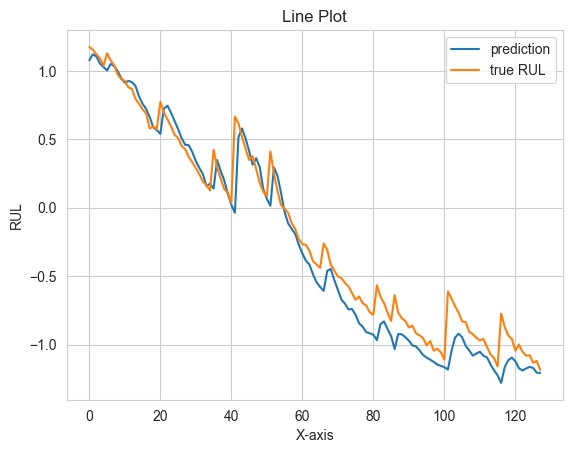

In [276]:
plot_series(rul_pred_lstm, processed_test_targets)

C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
C:\Users\86151\AppData\Local\Temp\ipykernel_2044\1651342271.py:26: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method='silverman'`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='type', y='value', data=df, split=True, in

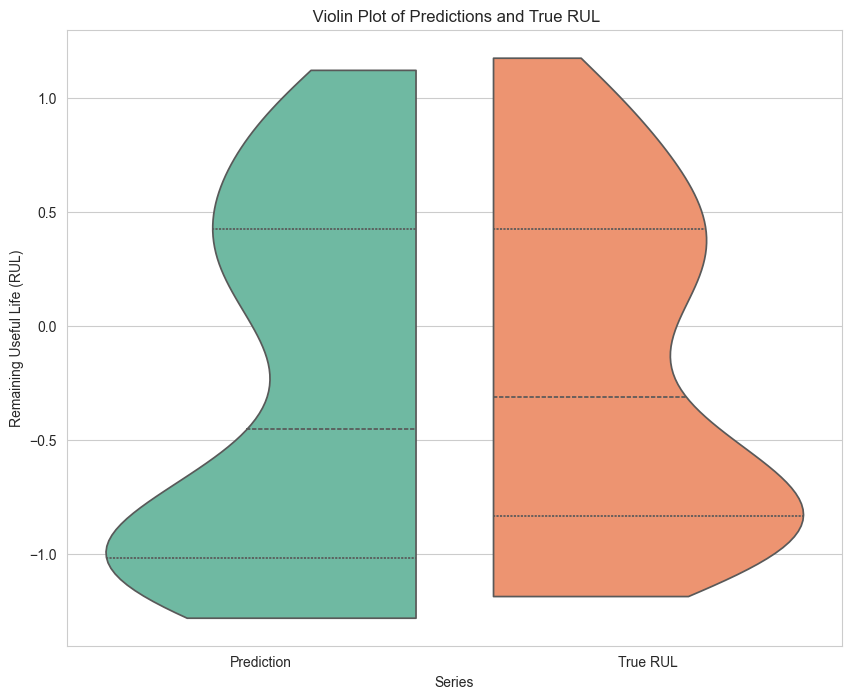

In [277]:
plot_series_violin(rul_pred_lstm, processed_test_targets)

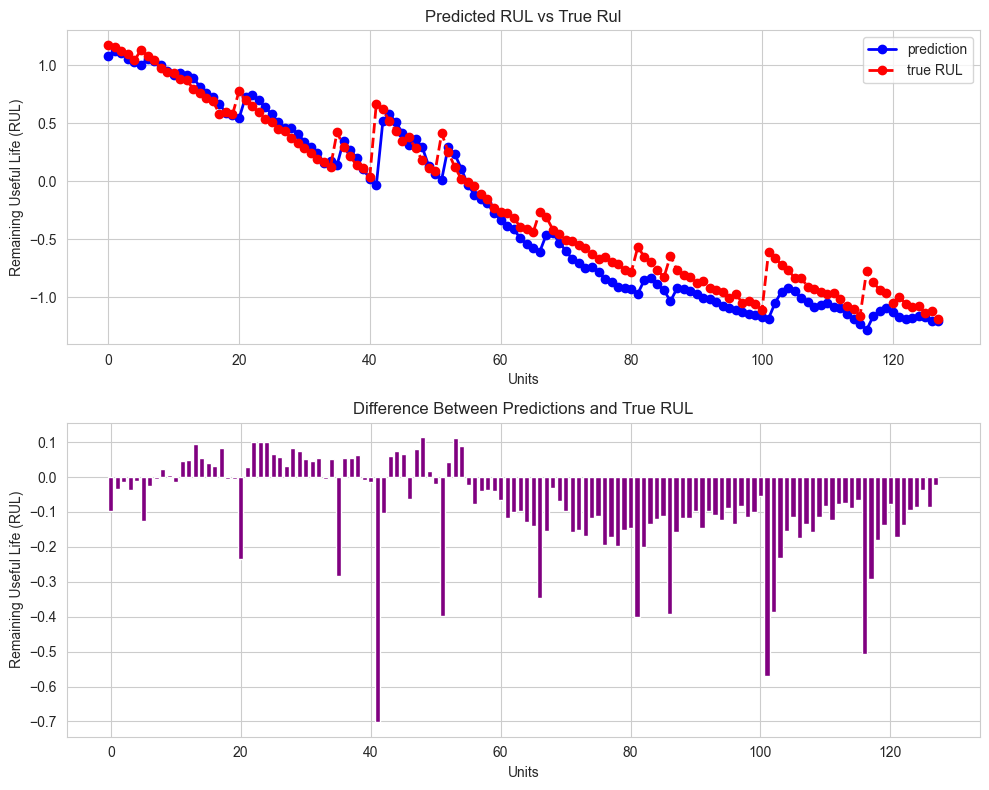

In [278]:
plot_series_diff(rul_pred_lstm, processed_test_targets)

# Attention based GRU

In [279]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(*kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        # note: 上一行是在自定义的 Seq2SeqEncoder 类的 call 方法中调用 RNN 层的前向传播操作
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

In [ ]:
'''
output[0]:
当 self.rnn 被调用时，如果设置了 return_sequences=True，它将返回一个包含每个时间步的输出的张量。这个张量的形状是 (batch_size, num_steps, num_hiddens)。
output[0] 指的是这个张量的第一个元素，即包含序列中每个时间步的输出。在 TensorFlow 的 RNN 层中，返回的 output 通常是一个元组，其中第一个元素是整个序列的输出，第二个元素是最终状态。但是，由于这里使用了 return_sequences=True 和 return_state=True，所以 output 直接是一个包含两个元素的张量，其中 output[0] 就是序列的输出。

state = output[1:]:
在 TensorFlow 的 RNN 层中，当 return_state=True 时，除了序列的输出外，还会返回最终的状态。这个状态是一个二维张量，形状为 (batch_size, num_hiddens)，表示序列处理完毕后 RNN 层的内部状态。
output[1:] 指的是从 output 张量的第二个元素开始的所有元素。在这个上下文中，由于 output 张量只包含两个元素（序列的输出和最终状态），output[1:] 实际上只会取到最终状态。因此，state 变量存储了 RNN 层的最终状态。
'''

In [ ]:
'''
在 TensorFlow 和 Keras 中，return_sequences 和 return_state 是循环神经网络（RNN）层的参数，它们控制 RNN 层的输出行为：

return_sequences=True:
这个参数用于指示 RNN 层是否应该返回每个时间步的输出。默认情况下，RNN 层只返回序列的最后一个输出。
当设置为 True 时，RNN 层将返回一个三维张量，形状为 (batch_size, num_steps, num_hiddens)，其中 batch_size 是批次中样本的数量，num_steps 是输入序列的长度，num_hiddens 是 RNN 层隐藏单元的数量。这个三维张量包含了序列中每个时间步的输出。

return_state=True:
这个参数用于指示 RNN 层是否应该返回其内部状态。这对于构建序列到序列（Seq2Seq）模型或在 RNN 层之后需要使用状态信息的情况非常有用。
当设置为 True 时，RNN 层将返回一个包含两个元素的元组。第一个元素是序列的输出（如果 return_sequences=True），第二个元素是 RNN 层的最终状态，形状为 (batch_size, num_hiddens)。这个状态可以被用来初始化另一个 RNN 层，或者用于其他需要使用 RNN 内部状态的场合。

在 Seq2SeqEncoder 类中，同时使用 return_sequences=True 和 return_state=True 可以让我们获取到序列的完整输出以及最终状态。这对于构建编码器-解码器架构的 Seq2Seq 模型是必要的，其中编码器的输出和状态将被传递给解码器。
'''

In [280]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):   # note: attention_size: 指定了注意力层的输出维度大小。
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size) # note: 在初始化方法中，定义了一个 tf.keras.layers.Dense 层，用于计算注意力分数。这个密集层的输出维度被设置为 attention_size。

    def call(self, state, encoder_outputs): # note: 这是层的前向传播方法，它定义了如何计算注意力权重并应用它们。
        # note: state: 这是解码器的隐藏状态，形状为 (batch_size, hidden_dims)，其中 batch_size 是批次中样本的数量，hidden_dims 是隐藏层的维度。encoder_outputs: 这是编码器的输出，形状为 (batch_size, num_steps, hidden_dims)，其中 num_steps 是输入序列的长度
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        # Hidden states of stacked GRU are first averaged before computing attention weights as done below
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

In [ ]:
# note: 在上面这段代码中，在这段代码中，AdditiveAttentionForSeq 是子类，它继承自 TensorFlow Keras 框架中的 tf.keras.layers.Layer 这个父类。

In [ ]:
'''
在 Python 中，super().__init__() 是一个特殊的调用，用于初始化父类（超类）。括号中的内容包括：

super(): 这是一个内置函数，用于返回代表父类的对象。在类继承体系中，它允许子类调用父类的方法。

(): 这是调用 super() 函数的括号。在 Python 3 中，super() 函数返回一个临时对象，这个对象绑定了父类的方法和当前的实例。

__init__(): 这是父类的构造方法（也称为初始化方法）。在调用 super() 时，你需要指定你想要调用的父类方法，这里就是 __init__ 方法，它是用来初始化父类实例的。

第二个括号 () 中的内容：在 __init__() 方法中，你可以传递参数给父类的构造器。这些参数可以是位置参数或关键字参数。在 super().__init__() 调用中，通常不直接传递参数，因为 super() 会自动转发当前方法接收到的参数到父类的 __init__ 方法。但是，如果你需要显式地传递参数，你可以在括号中指定它们。

例如，如果父类的 __init__ 方法需要一个名为 arg1 的参数，你可以这样写：

python
class Parent:
    def __init__(self, arg1):
        print("Parent's __init__ with arg1 =", arg1)

class Child(Parent):
    def __init__(self, arg1, **kwargs):
        print("Child's __init__ with arg1 =", arg1)
        super().__init__(arg1)  # 显式传递 arg1 到 Parent 的 __init__

# 创建 Child 类的实例
child_instance = Child('value1')
在这个例子中，super().__init__(arg1) 显式地将 arg1 参数传递给 Parent 类的构造器。然而，由于 super() 会自动转发参数，所以你通常可以省略这些参数，直接写 super().__init__()。

在 PyTorch 的 nn.Module 类中，super().__init__() 通常不需要额外的参数，因为 nn.Module 的构造器不接受额外的参数来初始化父类。但是，如果你的自定义类需要传递参数，你可以在括号中指定它们。
'''

In [281]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer): # note: 用于实现带有注意力机制的序列到序列（Seq2Seq）模型的解码器部分
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args): # note: 用于初始化解码器的状态。它接受编码器的输出和隐藏状态，并返回它们作为解码器的初始状态。
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state, **kwargs): # note: 层的前向传播方法，它定义了如何计算解码器的输出。
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # note: Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

In [282]:
class EncoderDecoder(tf.keras.Model): # note: 用于实现编码器-解码器（Encoder-Decoder）架构
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs): # note: encoder和decoder需要自己定义，在下段代码中就定义了
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs): # note: 模型的前向传播方法，它定义了如何通过编码器和解码器处理输入数据。
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [283]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

In [284]:
net = EncoderDecoder(encoder, decoder)

In [285]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for batch in data_iter:
            X, Y = [x for x in batch]
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, loss {l}')

In [287]:
print(train_dataset)

In [291]:
# 假设 processed_train_data 和 processed_train_targets 是 NumPy 数组
processed_train_data = processed_train_data.astype('float32')
processed_train_targets = processed_train_targets.astype('float32')

# 然后再次尝试创建 TensorFlow 数据集
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)

In [293]:
processed_val_data = processed_val_data.astype('float32')
processed_val_targets = processed_val_targets.astype('float32')
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)

In [294]:
processed_test_data = processed_test_data.astype('float32')
processed_test_targets = processed_test_targets.astype('float32')
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data)).batch(128).prefetch(tf.data.AUTOTUNE)

In [304]:
for batch in test_dataset:
    print(batch[0].shape)  # 打印特征数据的维度
    # 如果你的目标数据也在数据集中，你也可以打印它
    # print(batch[1].shape)  # 打印目标数据的维度
    break  # 只打印第一个批次的维度，如果你想打印所有批次，可以移除这行

(4, 5)


In [314]:
print(processed_test_data.shape)

(128, 4, 5)


In [ ]:
'''
对应后面的coding报错日志
对于代码
    “for batch in test_dataset:
    print(batch[0].shape)  # 打印特征数据的维度
    # 如果你的目标数据也在数据集中，你也可以打印它
    # print(batch[1].shape)  # 打印目标数据的维度
    break  # 只打印第一个批次的维度，如果你想打印所有批次，可以移除这行”
输出结果是“(4, 5)”
而对于代码
    “for batch in full_train_dataset:
    print(batch[0].shape)  # 打印特征数据的维度
    # 如果你的目标数据也在数据集中，你也可以打印它
    # print(batch[1].shape)  # 打印目标数据的维度
    break  # 只打印第一个批次的维度，如果你想打印所有批次，可以移除这行”
输出结果是“(128, 4, 5)”
test_dataset是2维张量，说明后面的full_train_dataset哪里搞错了，而不是这个模型不划分window
'''

In [295]:
# # note: 与之前不同的是，TensorFlow 的 RNN 层期望接收 TensorFlow 的数据类型，而不是 PyTorch 的数据类型（torch.float32）
# train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
# val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data)).batch(128).prefetch(tf.data.AUTOTUNE)

In [307]:
# 将训练集和验证集合并为训练集，因为这个模型里好像没用到验证集。。。
full_train_data = np.concatenate((processed_train_data, processed_val_data), axis=0)
full_train_targets = np.concatenate((processed_train_targets, processed_val_targets), axis=0)

In [327]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
full_train_targets = target_scaler.fit_transform(full_train_targets.reshape(-1, 1)).reshape(-1)

full_train_dataset = tf.data.Dataset.from_tensor_slices((full_train_data)).batch(128).prefetch(tf.data.AUTOTUNE) # note: batch_size设置成了128（之前那些模型设置的是32）

In [302]:
# # coding报错日志对应的错误代码
# # 创建训练集和验证集的 TensorFlow 数据集
# train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets))
# val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets))

# # 将训练集和验证集合并为原始的训练集
# full_train_dataset = train_dataset.concatenate(val_dataset)

# full_train_dataset = full_train_dataset.batch(128).prefetch(tf.data.AUTOTUNE) 

In [328]:
for batch in full_train_dataset:
    print(batch[0].shape)  # 打印特征数据的维度
    # 如果你的目标数据也在数据集中，你也可以打印它
    # print(batch[1].shape)  # 打印目标数据的维度
    break  # 只打印第一个批次的维度，如果你想打印所有批次，可以移除这行

(4, 5)


In [324]:
print(full_train_data.shape)
print(full_train_targets.shape)

(492, 4, 5)
(492,)


In [320]:
train_seq2seq(net, full_train_dataset, 0.001, 10)

ValueError: too many values to unpack (expected 2)

In [321]:
# 将数据集转换为 NumPy 迭代器
numpy_iter = full_train_dataset.as_numpy_iterator()

# 迭代并打印
for batch in numpy_iter:
    print(batch)  # 这将打印出批次的 NumPy 表示
    break  # 只打印第一个批次

[[[ 0.55356413 -0.0304107   0.34781528 -0.13746981  0.57722545]
  [ 0.5553411   0.01187101  0.34585533 -0.09319371  0.52673197]
  [ 0.52078104  0.08796971  0.34379596 -0.31171665  0.45213422]
  [ 0.4841796   0.11972427  0.3430358  -0.36851135  0.4012883 ]]

 [[-1.0412802   0.78150225  0.34590647 -1.0375603  -1.1219585 ]
  [-1.0389297   0.7690242   0.33914727 -0.8295538  -1.1204232 ]
  [-1.0381043   0.7578683   0.34948593 -0.7661044  -1.1201243 ]
  [-1.0757183   0.7654206   0.3498664  -0.8708366  -1.1460066 ]]

 [[-0.14000481  0.6084128   0.34994513 -0.6853749  -0.11057463]
  [-0.13721122  0.61196697  0.34883487 -0.64626837 -0.1352423 ]
  [-0.14311965  0.5896149   0.34650108 -0.36939946 -0.13660812]
  [-0.17482518  0.5949334   0.34391585 -0.3200998  -0.15962441]]

 ...

 [[-0.4031765   0.10389863  0.34691036  1.2983092  -0.06102578]
  [-0.44129875  0.10813835  0.34577492  1.3070096  -0.08705752]
  [-0.43824896  0.15458564  0.34790313  1.2117931  -0.08485756]
  [-0.47681853  0.0854333   

In [ ]:
'''coding报错日志：
对于代码“train_seq2seq(net, full_train_dataset, 0.001, 10)”的报错如下：

这个错误信息表明在尝试使用名为 seq2_seq_encoder 的 Seq2SeqEncoder 类的 rnn 层时，输入数据的形状与该层期望的形状不兼容。具体来说，rnn 层期望的输入应该是二维的，但实际上接收到了三维的输入数据。

错误信息的关键部分是这里：

Input 0 of layer "rnn" is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: (128, 4, 5)
这表示 rnn 层期望输入数据的形状至少应该有2个维度，但是实际上接收到了一个形状为 (128, 4, 5) 的三维张量。在这个形状中，128 是批次大小（batch size），4 是序列长度（sequence length），5 是特征维度（feature dimension）。

在 TensorFlow 的 RNN 层中，输入数据通常需要是三维的，形状为 (batch_size, sequence_length, feature_dim)。然而，在这个错误中，Seq2SeqEncoder 类中的 rnn 层似乎期望二维输入，这可能是由于该层的设计方式或者你的特定用例。

要解决这个问题，你需要检查 Seq2SeqEncoder 类中的 rnn 层的配置，确保它能够正确处理三维的输入数据。如果该层是你自定义的，你可能需要修改它的 call 方法，以确保它能够接受和处理三维的输入张量。

如果你的 Seq2SeqEncoder 类确实需要二维输入，那么你可能需要调整你的数据，使其符合这个要求。例如，如果你的数据是三维的，你可能需要使用 tf.squeeze 来移除单一维度，或者使用 tf.reshape 来重新塑形张量。

'''

In [ ]:
net.save_weights("RUL-ABGRU.h5")

In [329]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [330]:
# 定义 Seq2SeqEncoder
class Seq2SeqEncoder(nn.Module):
    def __init__(self, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqEncoder, self).__init__()
        self.rnn = nn.GRU(num_hiddens, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        output, state = self.rnn(x)
        return output, state

In [331]:
# 定义 AdditiveAttentionForSeq
class AdditiveAttentionForSeq(nn.Module):
    def __init__(self, attention_size):
        super(AdditiveAttentionForSeq, self).__init__()
        self.attention = nn.Linear(attention_size, 1)

    def forward(self, state, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        averaged_state = torch.mean(state, dim=0)
        state_rep = averaged_state.repeat(seq_len, 1)
        concat = torch.cat((state_rep, encoder_outputs), dim=2)
        scores = torch.tanh(self.attention(concat))
        attention_weights = torch.nn.functional.softmax(scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context

In [332]:
# 定义 Seq2SeqAttentionDecoder
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqAttentionDecoder, self).__init__()
        self.rnn = nn.GRU(num_hiddens, num_layers, dropout=dropout, batch_first=True)
        self.attention = AdditiveAttentionForSeq(attention_size=32)
        self.dense = nn.Linear(num_hiddens, 1)

    def init_state(self, enc_outputs):
        return enc_outputs

    def forward(self, dec_input, state):
        enc_outputs, _ = state
        context = self.attention(dec_input, enc_outputs)
        rnn_input = torch.cat((dec_input, context), dim=2)
        rnn_output, _ = self.rnn(rnn_input)
        output = self.dense(rnn_output.squeeze(1))
        return output, rnn_output

In [333]:
# 定义 EncoderDecoder
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs, _ = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)

In [335]:
# 数据预处理
processed_train_data = processed_train_data.astype(np.float32)
processed_train_targets = processed_train_targets.astype(np.float32)

# 创建 PyTorch 数据集和数据加载器
train_dataset = TensorDataset(torch.from_numpy(processed_train_data), torch.from_numpy(processed_train_targets))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 确保模型正确初始化
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)
model_aG = EncoderDecoder(encoder, decoder)

# 在将模型转移到设备之前创建优化器
optimizer = optim.Adam(model_aG.parameters(), lr=0.001)

# 然后将模型转移到设备
model_aG = model_aG.to(device)

loss_fn = nn.MSELoss()

def train_seq2seq(model, data_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch in data_loader:
            X, Y = batch
            X, Y = X.to(device), Y.to(device)
            dec_input = X[:, -1:, :]
            optimizer.zero_grad()
            Y_hat, _ = model(X, dec_input)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

In [336]:
# 调用训练函数
train_seq2seq(model_aG, train_loader, optimizer, loss_fn, 10)

RuntimeError: input.size(-1) must be equal to input_size. Expected 64, got 5

In [ ]:
# 保存模型权重
torch.save(model_aG.state_dict(), "RUL-ABGRU.pth")

# FD001

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 14.924283414675442    |
| MAE    | 11.69177043247223     |
| MAE    | 0.2015629544201476    |
| S-score| 433.61579520912676    |


last example

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 15.109726898982043    |
| % MAE only last examples          | 11.239905338287354    |
| % MAE only last examples          | 0.1641893299713881    |
| S-score                           | 420.54334755535365    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |


# FD002

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 25.969482183253387    |
| MAE    | 18.094825164875928    |
| MAE    | 0.3145206386108706    |
| S-score| 12846.982989204538    |


last examples

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE  | 25.820265111799944    |
| MAE           | 17.886208949402032    |
| % MAE          | 0.29021528456382106   |
| S-score                           | 10833.431179482766    |


| Metric                            | Last 5           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |


# fd003

last 5

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 13.79427836806829     |
| MAE only last examples          | 10.74395896434784     |
| % MAE only last examples          | 0.1779147971993347    |
| S-score                           | 257.0967840795584     |


last

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 15.141513175312488    |
| MAE    | 11.587211685180664    |
| MAE    | 0.2114921732809048   |
| S-score| 375.1661445415284    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE  | 13.79427836806829     | 15.141513175312488     |
| MAE          | 10.74395896434784     | 11.587211685180664     |
| % MAE           | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |


#fd004

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 29.38823677700239     |
| MAE    | 22.941654827902394    |
| MAE    | 0.43580475811149433   |
| S-score| 12748.783293038632    |


last

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 29.435246281099328    |
| MAE (Taking only last example)    | 22.830334198090338    |
| % MAE only last examples          | 0.39199495157984415   |
| S-score                           | 12513.92265158481     |


| Metric                            | Last 5 Example           | Last  Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Complete metrics

## FD001

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |

## FD002

| Metric                            | Last 5           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |

## FD003

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 13.79427836806829     | 15.141513175312488     |
| MAE                               | 10.74395896434784     | 11.587211685180664     |
| % MAE                             | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |

## FD004

| Metric                            | Last 5 Example           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Critical errors

| FD Group | MAE for Critical Predictions |
|----------|-----------------------------|
| FD001    | 1.119092305501302           |
| FD002    | 4.02860562394305            |
| FD003    | 3.9500357839796276          |
| FD004    | 9.075825423002243           |
